# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [1]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("Lab1.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

/home/cy/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/nbformat.py:12: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  warn("The `IPython.nbformat` package has been deprecated since IPython 4.0. "


FileNotFoundError: [Errno 2] No such file or directory: 'Lab1.ipynb'

## Group Number : 5

## Student 1 
### Name : Chaoyi Zhu
### ID : 5500524

## Student 2
### Name :
### ID :

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import re
import os

## 1. Visualization task – 1 A4

### 1a. Plot visualizations
### Data preprocessing

In [4]:
# Load the data
df_src = pd.read_csv(os.path.join('data', 'train_data.csv'))

# Number of Transactions
print("================= Number of Transactions =================")
print("Number of rows = " + str(len(df_src.index)))
print("Number of fraudulent transactions = " + str(len(df_src.loc[df_src['label'] == 1])))
print("Number of valid transactions = " + str(len(df_src.loc[df_src['label'] == 0])))

# Show part of the sample data
print("================= Show part of the sample data =================")
display(df_src.head(5))

def data_preprocessing(df_src):
    # Preprocessing the data
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df_src['card_id'])
    df_src['card_id'] = card_enc.transform(df_src.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df_src['ip_id'])
    df_src['ip_id'] = ip_enc.transform(df_src.ip_id)

    # 3.Remove NA values
    df_src.loc[df_src['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
    df_src.loc[df_src['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
    df_src.loc[df_src['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

    # 4.Country code
    unique_issuer_cc = df_src['issuercountrycode'].unique()
    unique_shopper_cc = df_src['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df_src['issuercountrycode'] = enc.transform(df_src.issuercountrycode)
    df_src['shoppercountrycode'] = enc.transform(df_src.shoppercountrycode)

    # 5.Change currency to EUR
    def conv(row):
        currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                         "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                         "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                         "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                         "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                         "CNY": 7.5541, "SEK": 10.635}
        return row['amount'] / (currency_dict[row['currencycode']]*100)
    df_src['amount_eur'] = df_src.apply(lambda x: conv(x), axis=1)

    # 6.Tx-variantcode
    enc1 = LabelEncoder()
    enc1.fit(df_src['txvariantcode'])
    df_src['txvariantcode'] = enc1.transform(df_src.txvariantcode)

    # 7.Currency code
    enc2 = LabelEncoder()
    enc2.fit(df_src['currencycode'])
    df_src['currencycode'] = enc2.transform(df_src.currencycode)

    # 8.Shopper interaction
    enc3 = LabelEncoder()
    enc3.fit(df_src['shopperinteraction'])
    df_src['shopperinteraction'] = enc3.transform(df_src.shopperinteraction)

    # 9.Cache accountcode_cc
    df_src['accountcode'] = df_src['accountcode'].apply(lambda x: re.sub('Account','',x))
    df_src['accountcode_cc'] = 0
    df_src.loc[(df_src['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
    df_src.loc[(df_src['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
    df_src.loc[(df_src['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
    df_src.loc[(df_src['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

    # 10.Account code
    enc4 = LabelEncoder()
    enc4.fit(df_src['accountcode'])
    df_src['accountcode'] = enc4.transform(df_src.accountcode)

    # 11.Card verification code supplied
    enc5 = LabelEncoder()
    enc5.fit(df_src['cardverificationcodesupplied'])
    df_src['cardverificationcodesupplied'] = enc5.transform(df_src.cardverificationcodesupplied)

    # 12. Mail id
    df_src.loc[df_src['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

    enc6 = LabelEncoder()
    enc6.fit(df_src['mail_id'])
    df_src['mail_id'] = enc6.transform(df_src.mail_id)

    # Validation result of CVC/CVV2
    df_src.loc[df_src['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

    # Feature Engineering
    df_src['countries_equal'] = (df_src['shoppercountrycode'] == df_src['issuercountrycode'])
    df_src.loc[df_src['countries_equal'] == False,'countries_equal'] = 0
    df_src.loc[df_src['countries_equal'] == True,'countries_equal'] = 1
    return df_src

df_src = data_preprocessing(df_src)
# show data after processing
print("=================Processed data=================")
display(df_src.head(10))

================= Number of Transactions =================
Number of rows = 189628
Number of fraudulent transactions = 276
Number of valid transactions = 189352
================= Show part of the sample data =================


,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
0,1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0
1,2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0
2,3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0
3,4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0
4,6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0


=================Processed data=================


,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,accountcode_cc,countries_equal
0,1,49,2,546097.0,4500.0,1,49,1,1,1,3,17805,12538,105460,0,52.175123,GB,1
1,2,49,3,557349.0,3395.0,1,49,1,1,1,3,115620,107432,29882,0,39.363232,GB,1
2,3,49,2,542011.0,3895.0,1,49,1,1,1,3,84651,87293,123743,0,45.160467,GB,1
3,4,49,8,465943.0,15345.0,1,49,0,0,0,3,99845,147089,14712,0,177.917169,GB,1
4,6,49,8,475127.0,5095.0,1,49,1,1,1,3,122624,56390,75841,0,59.073834,GB,1
5,8,49,8,475130.0,2325.0,1,49,0,0,0,3,17723,73821,96349,0,26.957147,GB,1
6,10,49,8,446291.0,10050.0,1,49,1,1,1,3,43402,65524,109435,0,116.524441,GB,1
7,11,49,8,446238.0,7000.0,1,49,1,1,1,3,82674,121644,64458,0,81.161302,GB,1
8,12,49,8,465943.0,5195.0,1,49,1,1,1,3,157111,160643,133779,0,60.233281,GB,1
9,13,49,8,475714.0,15000.0,1,49,1,1,1,3,161166,144211,119109,0,173.917076,GB,1


### (1) Transaction Amount

[Text(0, 0.5, 'Transaction Amount(EUR)')]

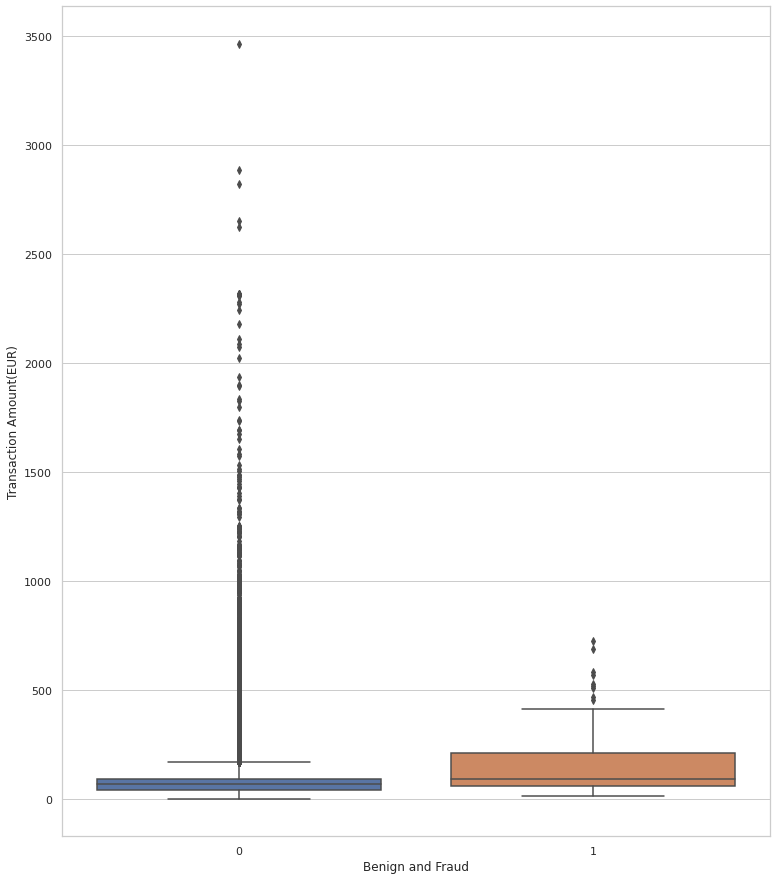

In [5]:
df_amount = df_src[['label', 'amount_eur']]
sns.set(rc={'figure.figsize':(12.7,15.27)})
sns.set_style("whitegrid")

ax = sns.boxplot(x='label',y='amount_eur', data=df_amount)
ax.set(xlabel = "Benign and Fraud")
ax.set(ylabel = "Transaction Amount(EUR)")


### (2) countries equal

In [6]:
df_ctr_equal = df_src[['label', 'countries_equal']]
df_ctr_equal = df_ctr_equal.value_counts()
df_ctr_equal = df_ctr_equal.to_numpy()

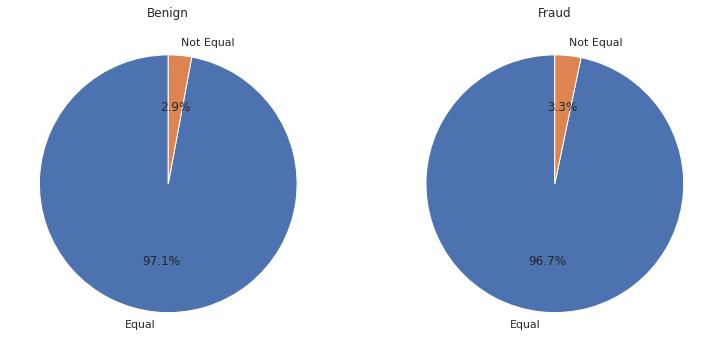

In [7]:
fig = plt.figure()
plt.subplot(1,2,1)
plt.pie(df_ctr_equal[:2], labels=['Equal', 'Not Equal'], autopct='%1.1f%%', startangle=90)
plt.title('Benign')
plt.subplot(1,2,2)
plt.pie(df_ctr_equal[2:], labels=['Equal', 'Not Equal'], autopct='%1.1f%%', startangle=90)
plt.title('Fraud')
plt.show()

### (3) TODO: Another plot

## 2. Imbalance task – 1 A4 – Individual

In [11]:
from sklearn.model_selection import train_test_split
# load data
data_src = pd.read_csv('data/train_data.csv')
# data preprocessing
data_src = data_preprocessing(data_src)
data_src = data_src.drop(columns=['Id','amount', 'accountcode_cc', 'countries_equal'])
data_src = data_src.drop(columns=['card_id','mail_id','ip_id'])
label_src = data_src['label']
data_src = data_src.drop(columns=['label'])
X_train, X_test, y_train, y_test = train_test_split(data_src, label_src, test_size=0.2)

In [48]:

class MySMOTE:
    """
    MySMOTE is a class that implements the SMOTE algorithm.
    """
    def __init__(self, n = 1, k = 5):
        self.n = n # Amount of SMOTE n%
        self.k = k # Number of nearest neighbors
        self.new_index = 0 # Index counter for new samples
        self.synthetic = None # Synthetic samples
        if self.n < 1:
            raise ValueError("The sample rate n must be greater than 1")

    def fit_resample(self, sample, label):
        sample_minor = sample[label == 1]
        self.synthetic = np.zeros((sample_minor.shape[0] * self.n, sample_minor.shape[1]))
        for i in range(sample_minor.shape[0]):
            # Get the neighbors of the current sample
            neighbors = self.get_neighbors(sample_minor, sample_minor[i])
            self.populate(sample_minor, i, neighbors)
        synthetic_label = np.ones(self.synthetic.shape[0])
        # Concatenate the synthetic samples with the original samples
        synthetic = np.concatenate((sample, self.synthetic), axis=0)
        synthetic_label = np.concatenate((label, synthetic_label), axis=0)
        return synthetic, synthetic_label

    def get_neighbors(self, X, x):
        """
        Get the k nearest neighbors of x in X.
        """
        distances = np.sqrt(np.sum((X - x)**2, axis=1))
        neighbors = np.argsort(distances)
        return neighbors[:self.k]

    def populate(self, sample, i, neighbors):
        for _ in range(self.n):
            nn = np.random.choice(neighbors)
            diff = sample[nn] - sample[i]
            gap = np.random.rand()
            self.synthetic[self.new_index] = sample[i] + gap * diff
            self.new_index += 1


### 2a. Print ROC curves

/home/cy/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.9981543004798819
after SMOTE: 357702
0.9873174075831883


/home/cy/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/cy/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/cy/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
/home/cy/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SGDClassifier was fitted with

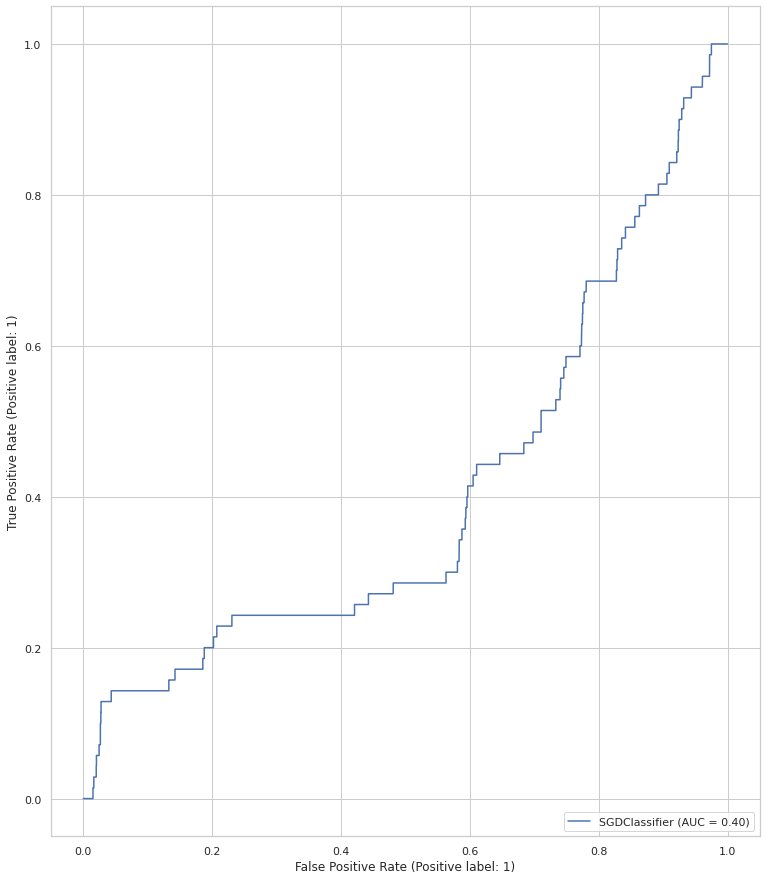

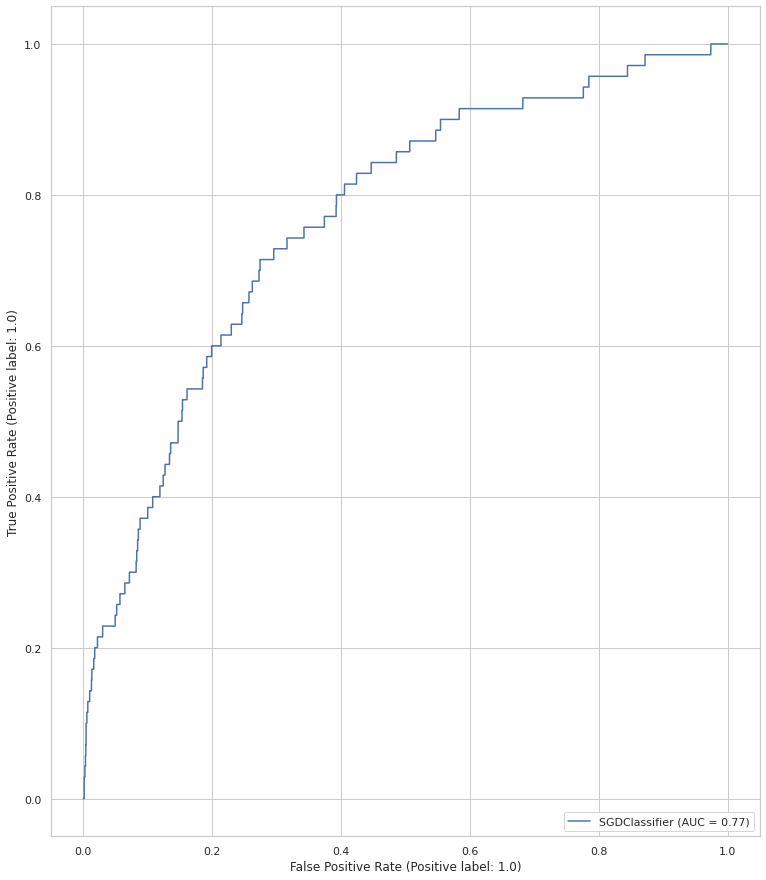

In [59]:
from sklearn.linear_model import SGDClassifier
import sklearn.neighbors
from imblearn.over_sampling import SMOTE
import sklearn.metrics as metrics
clf = SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(X_train, y_train)
metrics.plot_roc_curve(clf, X_test, y_test)
print(metrics.accuracy_score(y_test, clf.predict(X_test)))
metrics.confusion_matrix(y_test, clf.predict(X_test))
sm = MySMOTE(n=1000, k=2)
X_train_sm, y_train_sm = sm.fit_resample(X_train.to_numpy(), y_train.to_numpy())
#display(X_train_sm.head(10))
print("after SMOTE:",len(X_train_sm))
#print("Number of fraudulent transactions = " + str(len(y_train_sm.loc[y_train_sm == 1])))
#print("Number of valid transactions = " + str(len(y_train_sm.loc[y_train_sm == 0])))
clf.fit(X_train_sm, y_train_sm)
metrics.plot_roc_curve(clf, X_test, y_test)
print(metrics.accuracy_score(y_test, clf.predict(X_test)))


### 2b. Analyse the performance of the classifiers. Explain which method performs best.

### 2c. Is using SMOTE a good idea? Why (not)?

## 3. Privacy task – 1 A4 – Individual

### 3a. Print ROC curves

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

## 4. Classification task – 2 A4

### 4a. Print relevant plots and metrics with clear headings.

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

## 5. Bonus task – 1 A4

### 5a. Provide code and report below